In [211]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from astropy import units as u
from astropy.coordinates import SkyCoord

%matplotlib inline

In [260]:
msun = 1.9891E30
rsun = 695500000.
G = 6.67384E-11
AU = 149597870700.
def get_duration(per,ars,cosi=0.0,b=0,rprs=0.0):
    """
    returns the transit duration in days
    """
    part1 = (per/np.pi)
    part2 = 1./ ars
    part3 = (1+rprs)**2 - b**2
    part4 = np.sqrt(1 - cosi**2)
    duration = part1 * np.arcsin(part2 * part3 / part4)


    return duration

def per2ars(per,mstar,rstar):
    per_SI = per * 86400.
    mass_SI = mstar * msun
    a3 = per_SI**2 * G * mass_SI   / (4 * np.pi**2)
    return a3**(1./3.) / (rstar*rsun)


columns = ['RAdeg', 'DEdeg' ,'Rp', 'Per', 'S', 'K', 'Rstar', 'Teff', 
           'Vmag', 'Imag', 'Jmag', 'Ksmag', 'DM', 'Dil', 'logsigV', 
           'SNR','Mult']  
tess_catalog = pd.read_table('../data/apj516470t6_mrt.txt', skiprows=32, delim_whitespace=True, 
                              names=columns)

In [213]:
c = SkyCoord(ra=tess_catalog.RAdeg*u.degree, dec=tess_catalog.DEdeg*u.degree, frame='icrs')
ecoords = c.transform_to('barycentrictrueecliptic')

tess_catalog['elon'] = ecoords.lon.degree
tess_catalog['elat'] = ecoords.lat.degree

In [214]:
tess_catalog['obslen'] = 0.0

# this is super-duper rough. It should be an overestimate on observations length though.
tess_catalog['obslen'] = np.where(np.abs(tess_catalog.elat) >= 77.,351,tess_catalog['obslen'])
tess_catalog['obslen'] = np.where((np.abs(tess_catalog.elat) < 77.) & 
                                  (np.abs(tess_catalog.elat) >= 45.),54,tess_catalog['obslen'])
tess_catalog['obslen'] = np.where((np.abs(tess_catalog.elat) < 45.) & 
                                  (np.abs(tess_catalog.elat) > 6.),27,tess_catalog['obslen'])


In [215]:
tess_catalog['ntransits'] = np.around(tess_catalog.obslen / tess_catalog.Per)

In [243]:
print('{} total\n{} 4+ transits\n{} 3 transits\n{} 2 transits\n{} 2 or fewer transits'.format(
        tess_catalog.shape[0],
        np.nonzero(tess_catalog.ntransits >= 4.)[0].shape[0],
        np.nonzero(tess_catalog.ntransits == 3.)[0].shape[0],
        np.nonzero(tess_catalog.ntransits == 2.)[0].shape[0],
        np.nonzero((tess_catalog.ntransits <= 2.) & tess_catalog.ntransits >= 1.)[0].shape[0],
        ))

tess_catalog['bendek_targets'] = ((tess_catalog.ntransits <= 2.) * tess_catalog.ntransits >= 2.)

1984 total
1551 4+ transits
172 3 transits
189 2 transits
260 2 or fewer transits


In [244]:
bendek_catalog = tess_catalog[tess_catalog.bendek_targets].copy()

In [245]:
2 <= 2

True

In [246]:
bendek_catalog.loc[:, 'adjSNR'] = bendek_catalog.SNR / (np.sqrt(2) * np.sqrt(1.3))
bendek_catalog.loc[:, 'isdetected'] = np.where(bendek_catalog.adjSNR > 7.0, True, False)







In [247]:
bendek_catalog_SNR = bendek_catalog[bendek_catalog.adjSNR > 6.0]

In [248]:
# bendek_catalog_SNR[['Rp', 'Per', 'S', 'K', 'Rstar', 'Teff', 
#            'Vmag', 'Imag', 'adjSNR']]

np.sort(bendek_catalog_SNR.Rp).shape

(134,)

(array([ 52.,  45.,  21.,   7.,   3.,   3.,   0.,   1.,   0.,   2.]),
 array([ 0.0512244 ,  0.11903317,  0.18684195,  0.25465073,  0.32245951,
         0.39026828,  0.45807706,  0.52588584,  0.59369462,  0.66150339,
         0.72931217]),
 <a list of 10 Patch objects>)

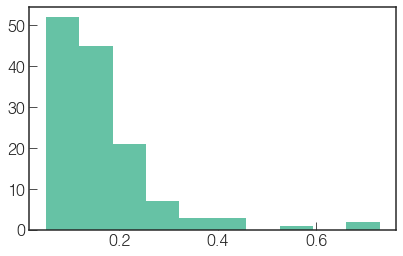

In [263]:
plt.hist(get_duration(bendek_catalog_SNR.Per, 
             per2ars(bendek_catalog_SNR.Per, bendek_catalog_SNR.Rstar, 
                                             bendek_catalog_SNR.Rstar)))

(0, 11)

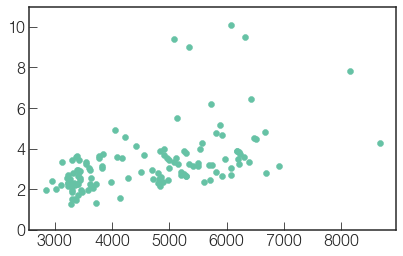

In [251]:
plt.scatter(bendek_catalog_SNR.Teff, bendek_catalog_SNR.Rp)
plt.ylim(0,11)

(45,)


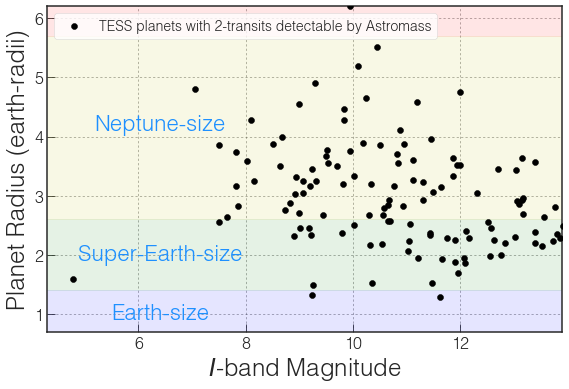

In [316]:
fig, ax = plt.subplots(1, 1, figsize=[8,5.5])
ax.scatter(bendek_catalog_SNR.Imag, bendek_catalog_SNR.Rp, label='TESS planets with 2-transits detectable by Astromass', color='k', zorder=100)

ax.fill_between([0,15],0,1.4, color='b', alpha=0.1)
ax.fill_between([0,15],1.4,2.6, color='g', alpha=0.1)
ax.fill_between([0,15],2.6,5.7, color='y', alpha=0.1)
ax.fill_between([0,15],5.7,11, color='r', alpha=0.1)

ax.set_xlim(4.3,13.9)

ax.set_ylim(0.7,6.2)

ax.set_xlabel('$I$-band Magnitude')
ax.set_ylabel('Planet Radius (earth-radii)')
ax.text(6.4, 1.0,'Earth-size', fontsize=22, color='dodgerblue', verticalalignment='center', 
        horizontalalignment='center')
ax.text(6.4, 2.0,'Super-Earth-size', fontsize=22, color='dodgerblue', verticalalignment='center', 
        horizontalalignment='center')
ax.text(6.4, 4.2,'Neptune-size', fontsize=22, color='dodgerblue', verticalalignment='center', 
        horizontalalignment='center')
ax.grid()
ax.legend(loc=2, )
fig.tight_layout()

print(bendek_catalog_SNR.Rp[(bendek_catalog_SNR.Rp >1.4) * (bendek_catalog_SNR.Rp <2.6)].shape)
fig.savefig('fig12-detected.png', dpi=150)

In [223]:
tdepth = ((bendek_catalog_SNR.Rp / bendek_catalog_SNR.Rstar) * 0.009154)**2

In [224]:
tdepth[tdepth < 0.003].shape

(100,)

In [264]:
# bendek_catalog_SNR[bendek_catalog_SNR.S < 1.5]

In [205]:
# how to predict transit times:

# 2 transits observed
# assume uncertainty 1-sigma of 5 mins in measuring transit time
# so uncertainty in T0 is 30 min, uncertainty in Porb is 30 min


def get_transit_unc(period):
    outarr = np.zeros([1000,np.arange(0,365.25*5 / period,1).shape[0]])
    for j in np.arange(0,1000,1):
        period_unc = np.random.normal(0,1./1440 * 5)
        T0_unc = np.random.normal(0,1./48./1440 * 5)

        ttime_measured = np.array([T0_unc + (i * (period+period_unc)) for i in np.arange(0,365.25*5 / period,1)])
        ttime_real = np.array([0 + (i * (period)) for i in np.arange(0,365.25*5 / period,1)])

        outarr[j] = (ttime_real-ttime_measured)
    #     plt.plot(np.arange(0,365.25*5 / period,1) * period / 356.25,(ttime_real-ttime_measured) * 24)
    return outarr


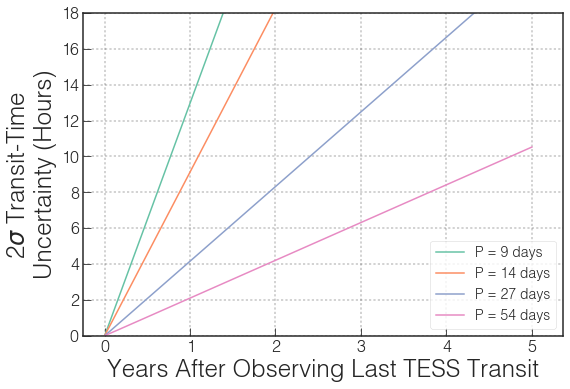

In [207]:
fig, ax = plt.subplots(1, 1, figsize=[8,5.5])

period=9
outarr = get_transit_unc(period)
# ax.fill_between(np.arange(0,365.25*5 / period,1) * period / 356.25, 
#                 np.percentile(np.abs(outarr), 5, axis=0) * 24.,
#                 np.percentile(np.abs(outarr), 95, axis=0) * 24.,
#                 alpha=0.2,
#                 color='red')
ax.plot(np.arange(0,365.25*5 / period,1) * period / 356.25, 
        np.percentile(np.abs(outarr), 95, axis=0) * 24. * 2, # multiply by two to account for early and late transits
#        color='red')
        label='P = 9 days'
        )


period=14
outarr = get_transit_unc(period)
# ax.fill_between(np.arange(0,365.25*5 / period,1) * period / 356.25, 
#                 np.percentile(np.abs(outarr), 5, axis=0) * 24.,
#                 np.percentile(np.abs(outarr), 95, axis=0) * 24.,
#                 alpha=0.2,
#                 color='blue')
ax.plot(np.arange(0,365.25*5 / period,1) * period / 356.25, 
        np.percentile(np.abs(outarr), 97.7, axis=0) * 24. *2.,
#        color='green')
        label='P = 14 days'
        )
# ax.plot(np.arange(0,365.25*5 / period,1) * period / 356.25, 
#         np.percentile(np.abs(outarr), 84.1, axis=0) * 24.,
# #        color='green')
#         label='P = 14 days'
#         )

# period=41
# outarr = get_transit_unc(period)
# # ax.fill_between(np.arange(0,365.25*5 / period,1) * period / 356.25, 
# #                 np.percentile(np.abs(outarr), 5, axis=0) * 24.,
# #                 np.percentile(np.abs(outarr), 95, axis=0) * 24.,
# #                 alpha=0.2,
# #                 color='green')
# ax.plot(np.arange(0,365.25*5 / period,1) * period / 356.25, 
#         np.percentile(np.abs(outarr), 95, axis=0) * 24.,
# #        color='blue')
#         )

period=27
outarr = get_transit_unc(period)
# ax.fill_between(np.arange(0,365.25*5 / period,1) * period / 356.25, 
#                 np.percentile(np.abs(outarr), 5, axis=0) * 24.,
#                 np.percentile(np.abs(outarr), 95, axis=0) * 24.,
#                 alpha=0.2,
#                 color='green')
ax.plot(np.arange(0,365.25*5 / period,1) * period / 356.25, 
        np.percentile(np.abs(outarr), 95, axis=0) * 24. * 2.,
#        color='blue')
        label='P = 27 days'
        )

period=54.
outarr = get_transit_unc(period)
# ax.fill_between(np.arange(0,365.25*5 / period,1) * period / 356.25, 
#                 np.percentile(np.abs(outarr), 5, axis=0) * 24.,
#                 np.percentile(np.abs(outarr), 95, axis=0) * 24.,
#                 alpha=0.2,
#                 color='green')
ax.plot(np.arange(0,365.25*5 / period,1) * period / 356.25, 
        np.percentile(np.abs(outarr), 95, axis=0) * 24. * 2.,
#        color='purple')
        label='P = 54 days'
        )

ax.grid(lw=2, alpha=0.2)
ax.set_xlabel('Years After Observing Last TESS Transit')
ax.set_ylabel('2$\sigma$ Transit-Time\nUncertainty (Hours)')
ax.legend()

ax.set_ylim(0,18)

fig.tight_layout()
fig.savefig('fig1-ttun.png', dpi=150)

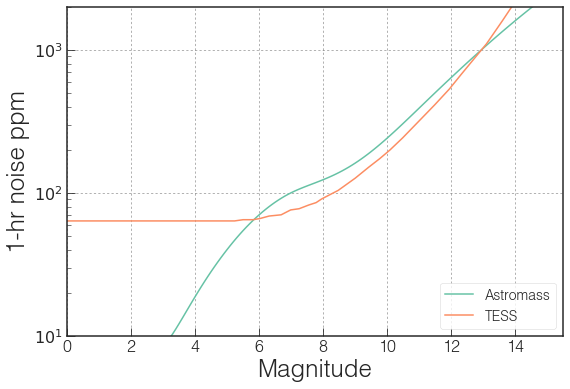

In [204]:
from scipy.interpolate import interp1d

fig, ax = plt.subplots(1, 1, figsize=[8,5.5])
bendekmag = np.array([2,5, 6, 7, 11.5, 15])
bendeknoise = np.array([10, 40, 70, 100, 500, 2400])

tessnoise = np.genfromtxt('/Users/tom/Projects/OccSim/code/TessNoise_1h.csv', skip_header=4, delimiter=',').T

f2 = interp1d(bendekmag, bendeknoise, kind='cubic')
plt.plot(np.arange(3,15,0.1), f2(np.arange(3,15,0.1)), label='Astromass')
plt.plot(tessnoise[0], tessnoise[1], label='TESS')

plt.xlim(0,15.5)

plt.ylim(10,2000)
plt.yscale('log')
plt.xlabel('Magnitude')
plt.ylabel('1-hr noise ppm')
plt.grid()
plt.legend()
plt.tight_layout()


In [154]:
tessnoise

array([[             nan,              nan,              nan,
                     nan,              nan,              nan,
                     nan,              nan,              nan,
                     nan,              nan,              nan,
                     nan,              nan,              nan,
                     nan,              nan,              nan,
                     nan,              nan,              nan,
                     nan,              nan,              nan,
                     nan,              nan,              nan,
                     nan,              nan,              nan,
                     nan,              nan,              nan,
                     nan,              nan,              nan,
                     nan,              nan],
       [  6.36100000e+01,   6.36100000e+01,   6.36100000e+01,
          6.48800000e+01,   6.48800000e+01,   6.61600000e+01,
          6.88200000e+01,   7.01900000e+01,   7.59300000e+01,
          7.74400000e+01,

In [210]:
bendek_catalog_SNR.obslen

9        27.0
10       27.0
15       27.0
22       54.0
30       27.0
33       54.0
41       27.0
47       27.0
83       27.0
91       27.0
92       27.0
93       54.0
94       27.0
105      27.0
107      27.0
116      27.0
121      27.0
128      27.0
131      27.0
136      27.0
146      54.0
162      27.0
164      54.0
171      27.0
173      27.0
177      54.0
185      27.0
189      54.0
196      27.0
210      27.0
        ...  
1646     27.0
1661     27.0
1695     54.0
1701     27.0
1711     54.0
1717     27.0
1727     54.0
1738    351.0
1741     54.0
1771     27.0
1803     27.0
1821     27.0
1830     54.0
1842     54.0
1843     27.0
1860     54.0
1872     27.0
1885     27.0
1896     27.0
1900     27.0
1909     54.0
1914     27.0
1930     27.0
1946     27.0
1968     27.0
1970     54.0
1971     27.0
1973     54.0
1975     27.0
1982     27.0
Name: obslen, dtype: float64